In [13]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd


import os

In [14]:
script_dir = os.getcwd() # Ga één map omhoog om 'baseline' te verwijderen en ga naar 'Data'
project_root = os.path.dirname(script_dir)  # Dit verwijdert 'baseline' van het script_dir
data_folder = os.path.join(project_root, "Identifier")

# 1. Dataset inladen
file_path = os.path.join(data_folder, "extracted_questions_dutch20.xlsx")
df = pd.read_excel(file_path)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud



# Basic dataset overview
print("Dataset Overview:")
print(df.info())
print(df.describe())

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())



Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26390 entries, 0 to 26389
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   context      26367 non-null  object
 1   question     26390 non-null  object
 2   statistical  26390 non-null  int64 
 3   theme        26390 non-null  object
 4   file_name    26390 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB
None
        statistical
count  26390.000000
mean       0.291739
std        0.454572
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Missing Values:
context        23
question        0
statistical     0
theme           0
file_name       0
dtype: int64


In [16]:
#

total_questions = len(df)
print(f"Total amount of Questions:{total_questions}")

# Count unique context cells
unique_contexts = df["context"].nunique()
print(f"Unique Contexts: {unique_contexts}")

# Count unique questions
unique_questions = df["question"].nunique()
print(f"Unique Questions: {unique_questions}")

# Concatenate context and question and count unique combinations
df["context_question"] = df["context"].astype(str) + " " + df["question"].astype(str)
unique_combinations = df["context_question"].nunique()
print(f"Unique Context-Question Combinations: {unique_combinations}")

Total amount of Questions:26390
Unique Contexts: 7904
Unique Questions: 19643
Unique Context-Question Combinations: 22032


In [19]:
# Identify duplicate context-question combinations
duplicates = df[df.duplicated("context_question", keep=False)]

# Save duplicates to an Excel file
duplicates.to_excel("duplicate_context_questions.xlsx", index=False)
print("Saved duplicate context-question combinations to 'duplicate_context_questions.xlsx'")

Saved duplicate context-question combinations to 'duplicate_context_questions.xlsx'


**Word- en tokencount nagaan voor Padding**

Hiermee kunnen we de wordcount en tokencount van de Bert modelen bekijken. Dit kan interessant zijn voor padding; of dus als we een maximum aantal tokens willen meegeven in de modellen om sneller de modellen te trainen. 

Token indices sequence length is longer than the specified maximum sequence length for this model (654 > 512). Running this sequence through the model will result in indexing errors


Tokenizing with Gro-NLP...


Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


Most common token count for Gro-NLP: 61
4 entries > 512 tokens for Gro-NLP (0.02%)

Tokenizing with RobBERT...


Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors


Most common token count for RobBERT: 51
4 entries > 512 tokens for RobBERT (0.02%)

Tokenizing with MultiBERT...
Most common token count for MultiBERT: 85
6 entries > 512 tokens for MultiBERT (0.02%)

Most common word count: 36



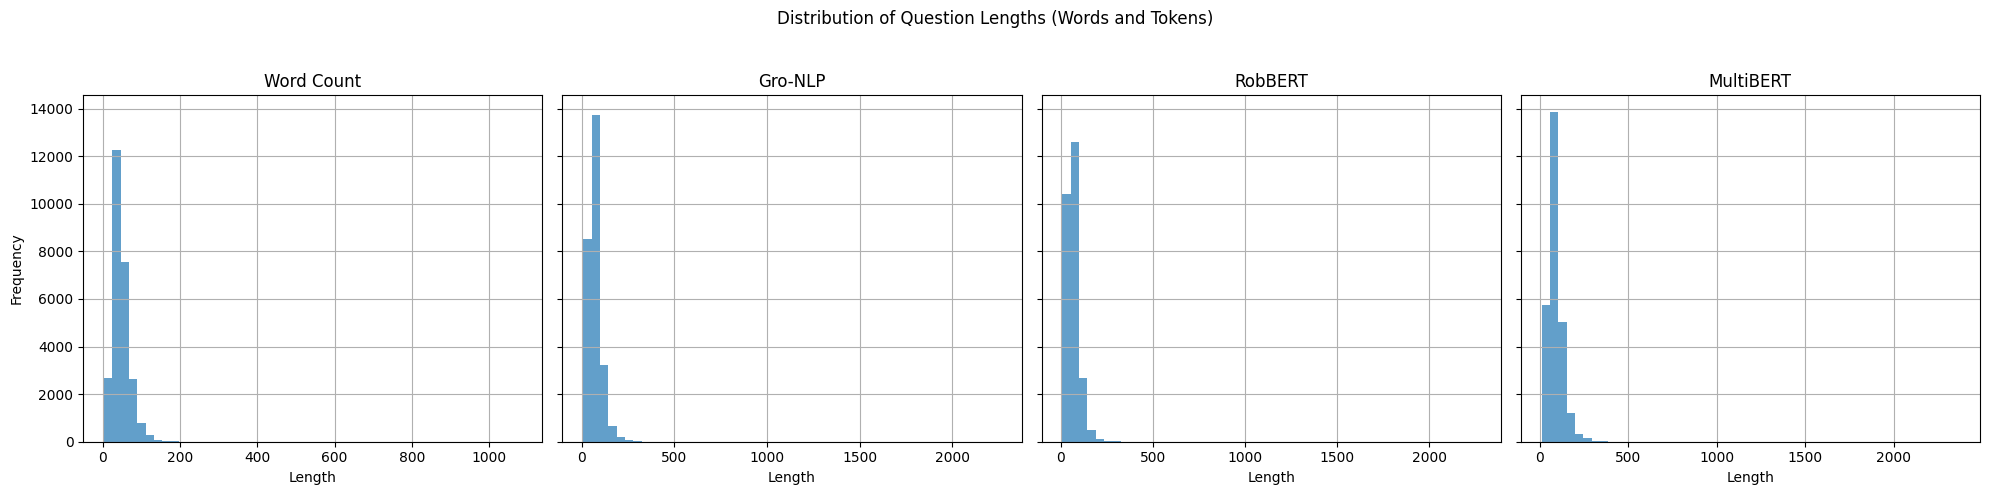

In [7]:
from transformers import AutoTokenizer, AutoModel

# Word count distribution
df["word_count"] = df["context_question"].apply(lambda x: len(str(x).split()))

# Load tokenizers
tokenizers = {
    "Gro-NLP": AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased"),
    "RobBERT": AutoTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base"),
    "MultiBERT": AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
}

# Token length distributions
token_lengths = {"Word Count": df["word_count"]}

# Tokenize and store lengths for each tokenizer
for name, tokenizer in tokenizers.items():
    print(f"Tokenizing with {name}...")
    df[f"{name}_tokens"] = df["context_question"].apply(lambda x: len(tokenizer.encode(x, truncation=False)))
    token_lengths[name] = df[f"{name}_tokens"]

    # Most common length
    most_common = df[f"{name}_tokens"].mode()[0]
    print(f"Most common token count for {name}: {most_common}")

    # Count entries > 512 tokens
    over_limit = (df[f"{name}_tokens"] > 512).sum()
    percentage = (over_limit / len(df)) * 100
    print(f"{over_limit} entries > 512 tokens for {name} ({percentage:.2f}%)\n")

# Most common word count
most_common_word_count = df["word_count"].mode()[0]
print(f"Most common word count: {most_common_word_count}\n")

# Plotting side-by-side histograms
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for ax, (name, lengths) in zip(axes, token_lengths.items()):
    ax.hist(lengths, bins=50, alpha=0.7)
    ax.set_title(name)
    ax.set_xlabel("Length")
    ax.grid(True)
axes[0].set_ylabel("Frequency")
plt.suptitle("Distribution of Question Lengths (Words and Tokens)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Conclusie: De averages liggen niet te ver van elkaar. 0.02% wordt hoe dan ook getruncate, omdat bert max 512 tokens inneemt. 0.02 is zeer laag en verwaarloosbaar. We zouden kunnen padden, dan kunnen we grotere batch sizes gebruiken en sneller trainen. Alhoewel we nog geen problemen hebben gehad met runnnen en we de context belangrijk achten kunnen we best momenteel de token size op 512 houden. 

**UMAP visualisatie.**

We doen een visualisatie van de cls embeddings van 2000 willekeurige zinnen voor en na het trainen van het model. Hierondeer de UMAP van ervoor, in de files waar de fine-tuning gebeurt is de na te vinden

Processing GroNLP BERT...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Embedding with GroNLP BERT: 100%|██████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.25it/s]
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP...
Processing RobBERT v2...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Embedding with RobBERT v2: 100%|███████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.28it/s]
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP...
Processing Multilingual BERT...


Embedding with Multilingual BERT: 100%|████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.02it/s]
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jefva\anaconda3\envs\bert_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP...


C:\Users\jefva\AppData\Local\Temp\ipykernel_22264\2868181647.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.86, 1])


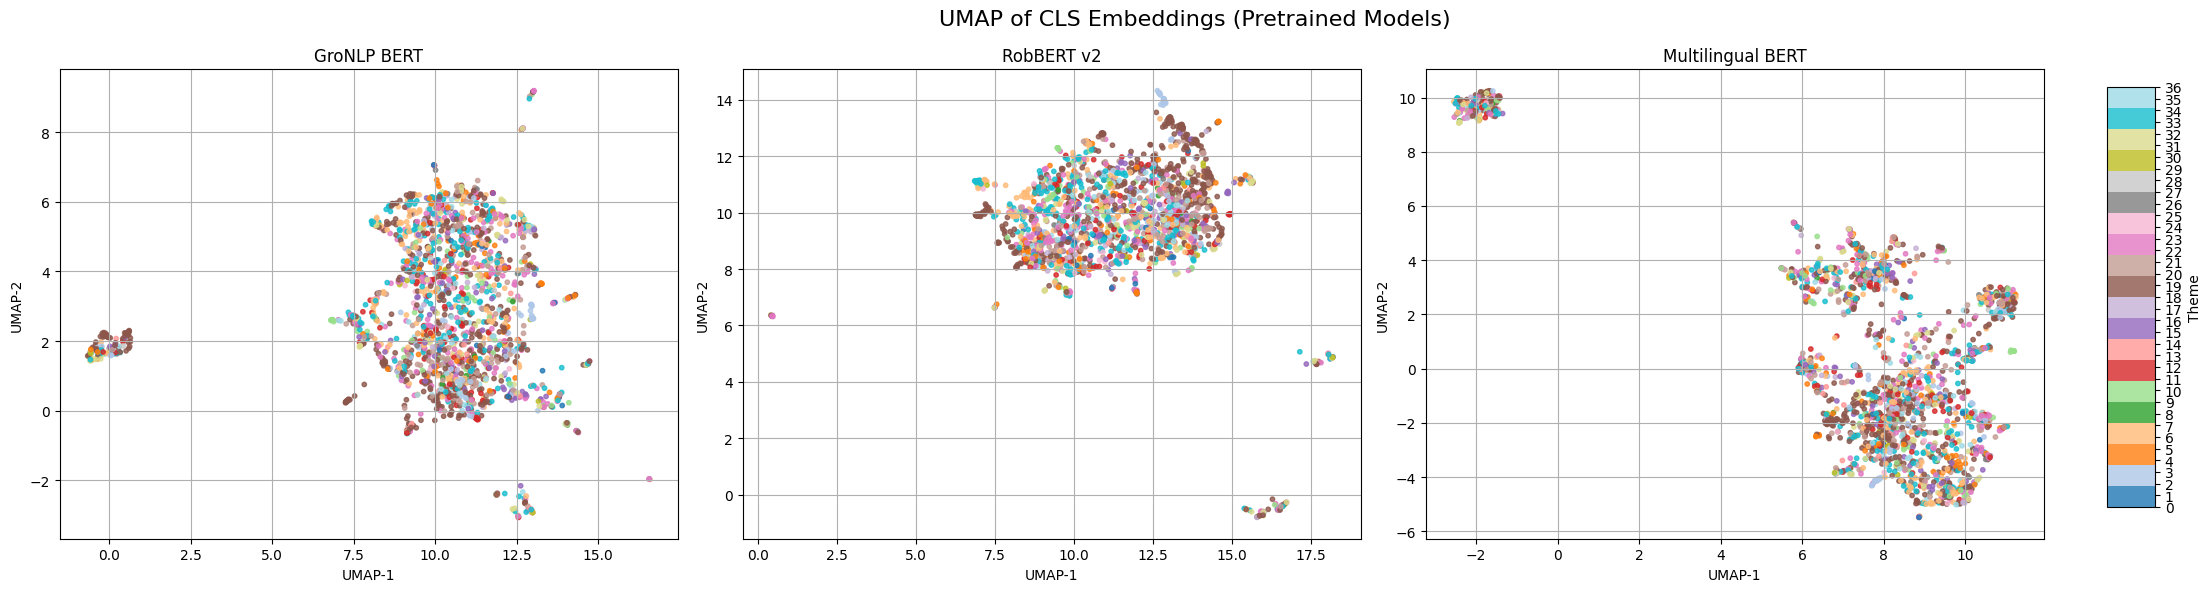

In [12]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import umap
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel

# Sample data (same sample for all models)
sample_df = df.sample(n=2000, random_state=42).copy()
texts = sample_df["context_question"].tolist()
themes = sample_df["theme"].tolist()

# Label encoding for consistent color mapping
le = LabelEncoder()
labels = le.fit_transform(themes)

# Model configurations
model_configs = {
    "GroNLP BERT": "GroNLP/bert-base-dutch-cased",
    "RobBERT v2": "pdelobelle/robbert-v2-dutch-base",
    "Multilingual BERT": "bert-base-multilingual-cased"
}

# Prepare plots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
fig.suptitle("UMAP of CLS Embeddings (Pretrained Models)", fontsize=16)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop over models
for ax, (name, model_name) in zip(axes, model_configs.items()):
    print(f"Processing {name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    embeddings = []

    for text in tqdm(texts, desc=f"Embedding with {name}"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_embedding.cpu().squeeze().numpy())

    print("Running UMAP...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    # Plot
    scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
    ax.set_title(name)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.grid(True)

# Add colorbar once for all plots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cb = fig.colorbar(scatter, cax=cbar_ax, ticks=range(len(le.classes_)))
cb.set_label("Theme")

plt.tight_layout(rect=[0, 0, 0.86, 1])
plt.show()


Conclusie: Nadat elk model is getraind nog eens een umap generaten op basis van de cls tokens van de validation/Test set (!!) -. Dan vergelijken met deze. Als ze beter geordend zijn is er vooruitgang.  